In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn import linear_model, metrics, model_selection, feature_selection, pipeline, ensemble, tree
from sympy import *
from sympy.stats import *

In [8]:
h = Function('h')
D = IndexedBase('D')
i = Symbol('i')
m = Symbol('m')
n = Symbol('n')
A = IndexedBase('A')
Y = IndexedBase('Y')
Yhat = IndexedBase('Yhat')
Z = IndexedBase('Z')

## Tasniflendirmede varsayimlar

In [9]:
from sklearn import datasets
import scipy.stats as scs
from ipywidgets import interact

In [10]:
np.random.seed(23)
X = np.random.randn(100, 2)
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3.5, 100))

Su anda modelin altinda yatan gercek fonksiyonun mahiyetini ihmal ederek, yalnizca modelin [0, 1] araliginda bir cikti verdigini ve bu ciktinin bir Bernoulli rassal degiskeninin $p$ parametresi olarak kullanilip ornek icin bir etiket orneklendigini varsayalim:

In [11]:
@interact(intersept=(-5,5,0.1), b0=(-10, 10, 0.1), b1=(-10, 10, 0.1))
def berno_viz(intersept=0.0, b0=3.0, b1=3.0):
    b = np.array([b0, b1])
    z = X @ b + intersept
    zz = (np.array([xx.ravel(), yy.ravel()]).T @ b + intersept).reshape(xx.shape)


    pzz = 1 / (1 + np.exp(-zz))
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, pzz, cmap='viridis', vmin=0, vmax=1, levels=20, alpha=0.5)
    plt.colorbar().set_label("Sucicegi olma olasiligi (Gercek model, $p=f(X)$)")
    berno = 1 / (1 + np.exp(-z))
    y = scs.bernoulli.rvs(p=berno)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k', label='Orneklenen etiketler')
    plt.legend()
    plt.subplot(1, 2, 2)
    # plt.contourf(xx, yy, zz, cmap='viridis', alpha=1.0, levels=20, vmin=-20, vmax=20)
    plt.scatter(X[:, 0], X[:, 1], c=berno, s=50, cmap='viridis', edgecolors='k')
    plt.colorbar().set_label("Ornegin sucicegi olma olasiligi")

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='intersept', max=5.0, min=-5.0), FloatSlider(value=3.…

Datasetimizi sabitleyelim.

In [13]:
b = np.array([4.0, 3.9])
intersept = 0.0
z = X @ b + intersept
# her orneklem icin etiketi belirleyecek olan Bernoulli dagiliminin p parametreleri
berno = 1 / (1 + np.exp(-z))  # Bu fonksiyonun ne oldugu simdilik onemsiz

In [14]:
berno

array([9.40956544e-01, 6.43180249e-01, 2.15424734e-01, 2.71489000e-03,
       8.35238343e-01, 7.72715899e-01, 8.21188944e-01, 2.99656713e-04,
       9.97912223e-01, 1.64779866e-05, 9.63370562e-01, 9.95130636e-01,
       6.00662108e-02, 9.87837983e-01, 1.66892722e-02, 9.99416774e-01,
       9.99974895e-01, 7.83815094e-03, 7.85438190e-05, 9.11885738e-01,
       9.75964026e-01, 9.64008151e-01, 3.86392390e-01, 9.78050317e-01,
       2.11211864e-02, 5.63938302e-01, 9.28345606e-01, 4.55902769e-04,
       1.98677361e-01, 9.82101739e-01, 1.02462580e-01, 8.54300930e-01,
       9.49007733e-01, 9.99999734e-01, 1.36218491e-02, 9.99022652e-01,
       9.94560162e-01, 1.10777934e-01, 3.54391642e-01, 6.88733367e-02,
       9.61837312e-01, 9.99986637e-01, 8.02929700e-04, 9.99965036e-01,
       1.94127975e-01, 8.94776820e-01, 9.93548075e-01, 8.87390348e-02,
       6.09543321e-03, 9.41016781e-01, 7.41613519e-01, 7.30436544e-05,
       8.60355903e-01, 1.65059908e-04, 1.92259261e-05, 1.45021798e-03,
      

In [16]:
y = scs.bernoulli.rvs(p=berno)

In [17]:
y

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int64)

Buradan itibaren yukarida gordugumuz katsayilari ve intersepti unutuyoruz.

Gozlemledigimiz data `X` ve `y` ile basbasayiz.

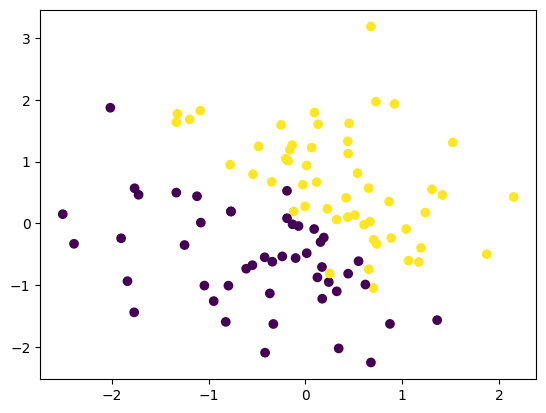

In [18]:
plt.scatter(*X.T, c=y)

### Likelihood Fonksiyonu ###

Daha once regresyonda, belli kabuller altinda gozlenen veriye gore en olasi hipotezi elde etmemizi saglayacak bir ifade yazmistik.

Aynisi tasniflendirme gorevi icin de yapabilir miyiz?


$$ \argmax_h{P(h | D)} = \argmax_h{P(D | h)} $$

$$ P(D | h) = \prod_{i=0}^{m-1}{P(D_i | h)} $$

Hipotez fonksiyonumuz $h$'in, herhangi bir girdiyi alip bir olasilik cikti verdigini kabul edelim.

$$ h(D_i) \in [0, 1] $$

Fonksiyonumuz, verilen girdi icin;

Ornegin, hipotez fonksiyonumuz herhangi bir girdi icin $0.3$ cevabini veriyorsa, $P(y=1 | h)$ kac olur?

Hipotezin dogru oldugu kabulu altinda, aslinda hipotezimizin urettigi sayi orneklem icin Bernoulli dagiliminin $p$ parametresidir.

Oyleyse, $Bernoulli(0.3)$ rassal degiskeninin 1 gelme ihtimali $0.3$ degil midir? (Ayni sekilde, 0 gelme ihtimali de $1-h(X) = 0.7$ olacaktir.)

Bu ifadeyi tek bir orneklem icin asagidaki gibi genelleyebiliriz:

$$  P(D_i | h) = h(D_i)^{Y_i} (1 - h(D_i))^{1 - Y_i} $$

Tum orneklerin etiketlerinin gozlenme olasiligi ise, dogal olarak, yukaridaki ifadeyi tum ornekler icin hesaplayip birbirleriye carparak elde edilebilir:

(Orneklerin birbirinden bagimsiz olduklari kabulu ile)

$(1)$
$$  P(D | h) = \prod_{i=0}^{m-1}{h(D_i)^{Y_i} (1 - h(D_i))^{1 - Y_i}} $$



Logaritmanin monotonik bir fonksiyon oldugunu gormustuk. Oyleyse

$$ \argmax_h{P(D | h)} = \argmax_h{\log{P(D | h)}} $$

Denklem $(1)$'in logaritmasini alarak asagidaki ifadeye erisebiliriz:

$$loglikelihood = \sum_{i=0}^{m-1}{Y_i \log{h(D_i)} + (1 - Y_i) \log{(1 - h(D_i))}} $$

Log-likelihood fonksiyonunu maksimize etmek, bunun eksi ile carpilmisini minimize etmeye esit oldugundan; olusan ifadeyi eksi ile carparsak:

$$\argmax_h{\log{P(D | h)}} = \argmin_h{-\log{P(D | h)}}$$
$$=\argmin_h{\sum_{i=0}^{m-1}{-Y_i \log{h(D_i)} - (1 - Y_i) \log{(1 - h(D_i))}} } $$

Elde etmis oldugumuz ifade, literaturde **binary cross-entropy loss** olarak gecen ikili capraz entropi kayip fonksiyonudur.

>Bu kaybi minimize eden hipotez, *likelihood*'u da ayni zamanda maksimum yapmaktadir.

In [19]:
def bce(y, yhat):
    return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)

In [20]:
bce(1, 0.98)

0.020202707317519466

In [21]:
bce(1, 0.24)

1.4271163556401458

In [23]:
bce(0, 0.02)

0.020202707317519466

In [24]:
bce(0, 0.76)

1.4271163556401458

In [26]:
bce(0,9)

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\3237035706.py:2: RuntimeWarning: invalid value encountered in log
  return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)


nan

In [29]:
bce(0,1)

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\3237035706.py:2: RuntimeWarning: divide by zero encountered in log
  return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)


inf

In [30]:
bce(0,0)

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\3237035706.py:2: RuntimeWarning: divide by zero encountered in log
  return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)
C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\3237035706.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)


nan

In [22]:
t = np.linspace(1e-18, 1-1e-18, 100)

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\3237035706.py:2: RuntimeWarning: divide by zero encountered in log
  return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)
C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\3237035706.py:2: RuntimeWarning: invalid value encountered in multiply
  return -y * np.log(yhat) - (1. - y) * np.log(1. - yhat)


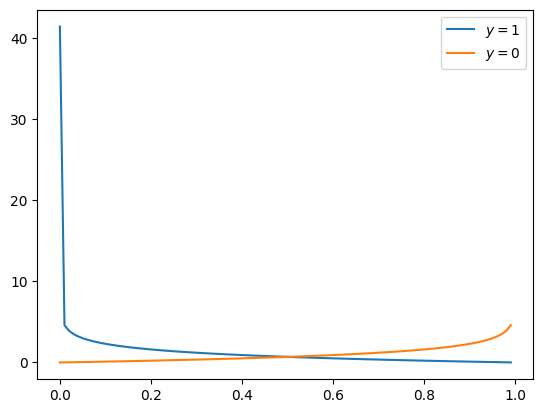

In [25]:
plt.plot(t, bce(1, t), label='$y=1$')
plt.plot(t, bce(0, t), label='$y=0$')
plt.legend()

In [31]:
bce(0, 0.02)

0.020202707317519466

In [33]:
bce(0, 1e-18)

-0.0

In [34]:
bce(0, 1-1e-8)

18.420680738927608

### Hipotezin mahiyeti

Yalnizca $[0, 1]$ araliginda cikti veren hipotez fonksiyonumuzun mahiyetini simdiye kadar ihmal etmistik.

Peki yalnizca bu deger araliginda cikti veren bir fonksiyon nasil bir fonksiyon olabilir?

Boyle bir fonksiyon elde edebilmek icin olaya tersten yaklasmayi deneyelim:

In [38]:
(np.sin(-3335455511) + 1) / 2

0.3794512582952554

In [40]:
np.abs(np.sin(-234242))

0.9903051892621146

### Olasilik, Odds ve Logit


Asagida olasiligin kendisine karsi bir plotunu goruyorsunuz. Burada ilginc bir olay yok.

In [42]:
x = Symbol('x')

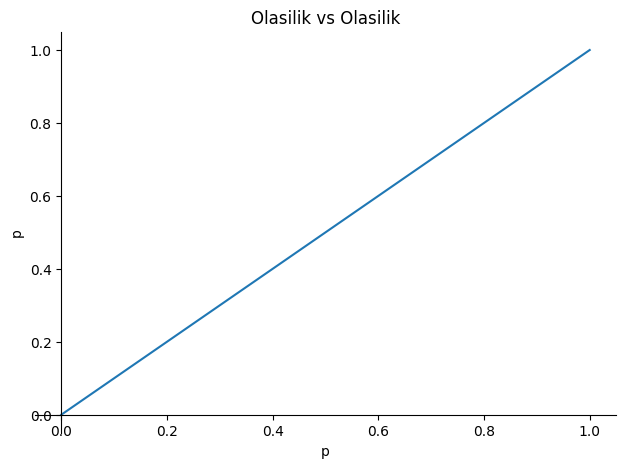

In [43]:
plot(x, (x, 0, 1), xlabel='p', ylabel='p', title="Olasilik vs Olasilik");

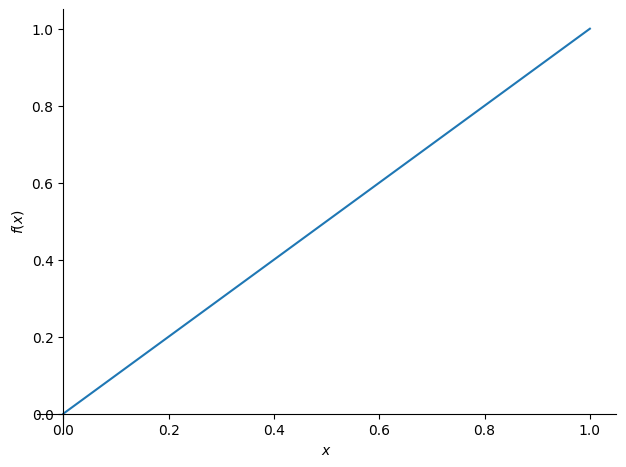

In [45]:
plot(x, (x, 0, 1))

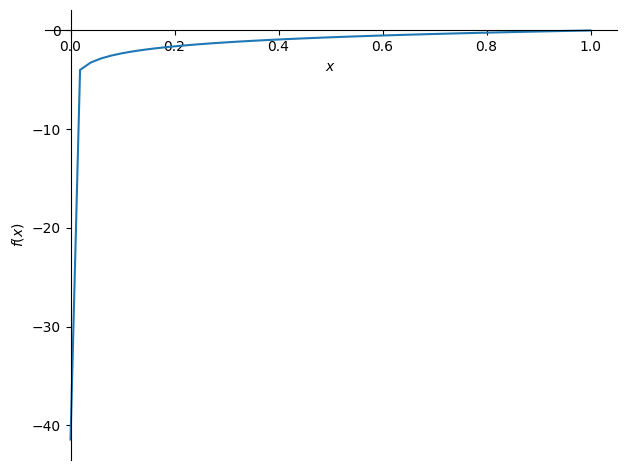

In [48]:
plot(log(x), (x, 1e-18, 1))

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\2082769325.py:2: RuntimeWarning: invalid value encountered in power
  plt.plot(t, (-.5)**t)


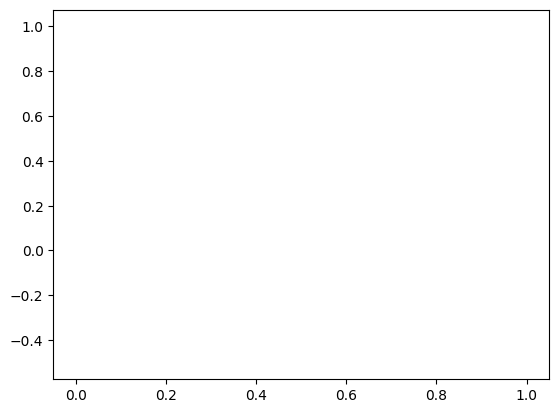

In [56]:
t = np.linspace(0, 1, 1000)
plt.plot(t, (-.5)**t)

In [57]:
(-.5)**t

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\1601107051.py:1: RuntimeWarning: invalid value encountered in power
  (-.5)**t


array([ 1. ,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

<string>:1: RuntimeWarning: invalid value encountered in double_scalars


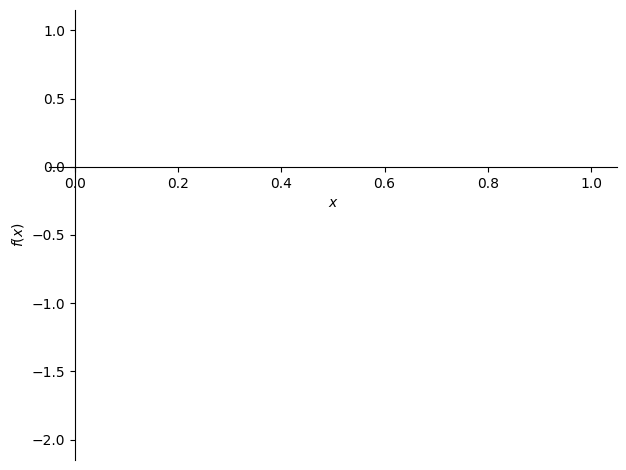

In [53]:
plot((-.5)**-x, (x, 0, 1))

#### Odds


Odds kavraminin Turkce'deki karsiligi *oran(?)* olup, 

$$\frac{p}{1-p}$$

seklinde ifade edilmektedir.

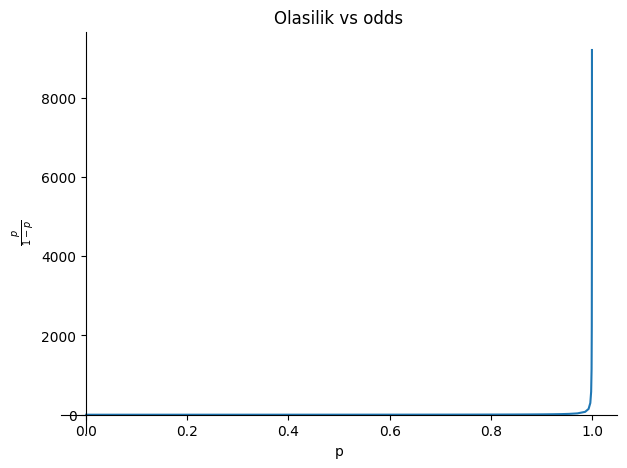

In [58]:
plot(x/(1-x), (x, 0., 1.), title='Olasilik vs odds', xlabel='p', ylabel=r'$\frac{p}{1-p}$');

Bu ifadenin $[0, 1]$ araligindaki olasiligi $[0, \infty]$ araligina haritaladigini goruyorsunuz.

#### Logit

Son olarak, elde etmis oldugumuz *odds* degerinin logaritmasini alirsak:

In [33]:
log(x/(1-x))

log(x/(1 - x))

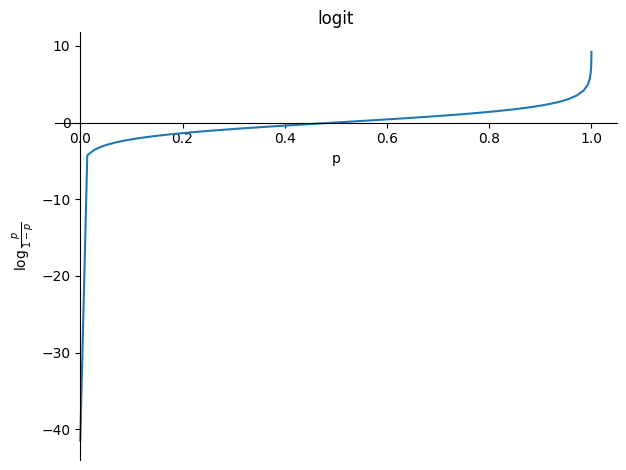

In [59]:
plot(
    log(x/(1-x)),
    (x, 1e-18, 1. - 1e-18), 
    title='logit', xlabel='p', ylabel=r'$\log \frac{p}{1-p}$');

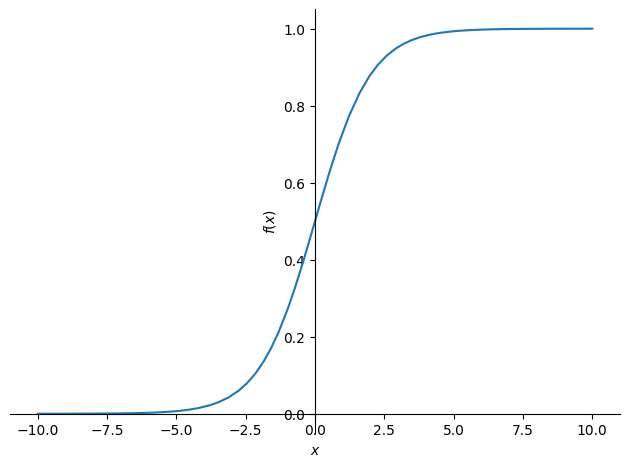

In [61]:
plot(exp(x) / (exp(x) +1))

Artik elimizde $[0, 1]$ araligindaki bir degeri $[-\infty, \infty]$ araligina haritalayan bir fonksiyon bulunmakta.

Bu fonksiyonun tersini alarak herhangi bir $[-\infty, \infty]$ araligindaki herhangi bir $x \in \mathbb{R}$ sayisini $[0, 1]$ araligina haritalayabiliriz.

In [60]:
p = Symbol('p')

display(Eq(x, log(1/(1-p))))
display(Eq(exp(x), p/(1-p)))
display(Eq(exp(-x), (1-p)/p))
display(Eq(exp(-x), (1-p)/p))
display(Eq(exp(-x), 1/p - 1))
display(Eq(p, 1/(1+exp(-x))))


Eq(x, log(1/(1 - p)))

Eq(exp(x), p/(1 - p))

Eq(exp(-x), (1 - p)/p)

Eq(exp(-x), (1 - p)/p)

Eq(exp(-x), -1 + 1/p)

Eq(p, 1/(1 + exp(-x)))

Kucuk bir manipulasyonla fonksiyonun tersini alarak elde etmis oldugumuz bu ifade, tanidik gelmekte midir?

$$ p = \frac{1}{1 + e^{-x}}$$

> Sigmoid(lojistik) fonksiyonu

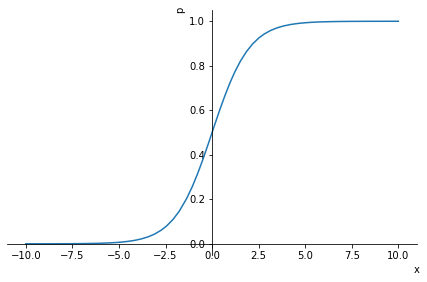

In [38]:
plot(1/(1 + exp(-x)), ylabel=p);

In [171]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [172]:
sigmoid(10.)

0.9999546021312976

In [173]:
sigmoid(-10.)

4.5397868702434395e-05

In [174]:
sigmoid(0.)

0.5

### Sigmoid isiginda hipoteze tekrar bakis

Elimizde $[-\infty, \infty]$ araliginda bir degeri $[0, 1]$  araligina haritalayan sigmoid fonksiyonu bulunduguna gore, hipotezimize tekrar bakalim.

$$h(x) = \frac{1}{1 + e^{-g(x)}}$$

Hipotezimizin son adimi sigmoid fonksiyonu olacak sekilde, $g(x)$ fonksiyonu hakkinda gorece serbest davranabiliriz (lineer, polinomiyel, logaritmik, ...).

Baslangic olarak $g(x)$ fonksiyonunun lineer bir fonksiyon oldugunu kabul edelim:

$$g(x) = ax + b$$

Bu durumda hipotez fonksiyonumuz suna donusecektir:

$$  h(x) = \frac{1}{1 + e^{-(ax + b)}}$$

Boyle bir hipotezin $a$,$b$ parametrelerini, maksimum likelihood'u (ya da minimum capraz entropiyi) verecek sekilde nasil optimize ederiz?

### Binary cross-entropy kayip fonksiyonu icin GD guncelleme kurali

#### Opsiyon 1

$$ J(\hat{Y}) = \sum_{i=0}^{m-1}{-Y_i \log{\hat{Y}_i} - (1 - Y_i) \log{(1 - \hat{Y}_i)}} $$


Hipotez fonksiyonumuzu  $\hat{Y}$ yerine koyarsak:

($a$ ve $b$ parametrelerini $\beta$ gibi tek bir matris parametre olacak sekilde birlestirerek)

$$ J(\hat{Y}) = \sum_{i=0}^{m-1}{-Y_i \log{\frac{1}{1+e^{-(X_i \beta)}}} - (1 - Y_i) \log{(1 - \frac{1}{1+e^{-(X_i \beta)}})}} $$


Bu ifadenin $\beta$'ya gore dogrudan turevlerini alip, $\beta$'yi guncelleyerek maliyeti minimize edebiliriz.

#### Opsiyon 2

Kaybi hesaplarken adim adim giderek hesaplama yapiyorsak, turevi de parca parca hesaplayip **zincir kurali** ile her bir parametre icin turevleri bulamaz miyiz?

Hesaplamamizda 3 adim var:

(1)
$$ Z_i = X_i \beta $$


$(2)$
$$ \hat{Y_i} = \frac{1}{1 + e^{-Z_i}} $$

$(3)$
$$ J(\hat{Y}) = \sum_{i=0}^{m-1}{-Y_i \log{\hat{Y}_i} - (1 - Y_i) \log{(1 - \hat{Y}_i)}} $$

Turevlere parca parca bakalim:

---

$(3)$ icin: 

$$ J(\hat{Y}) = \sum_{i=0}^{m-1}{-Y_i \log{\hat{Y}_i} - (1 - Y_i) \log{(1 - \hat{Y}_i)}} $$
$$ \frac{dJ}{d\hat{Y}} = \frac{1 - Y_i}{1 - \hat{Y}_i} - \frac{Y_i}{\hat{Y}_i} $$


---

$(2)$ icin:
$$ \hat{Y_i} = \frac{1}{1 + e^{-Z_i}} $$
$$ \ln{\hat{Y_i}} = - \ln{(1 + e^{-Z_i})} $$
$$ \frac{\frac{d\hat{Y_i}}{d{Z_i}}}{\hat{Y_i}} = \frac{e^{-Z_i}}{(1 + e^{-Z_i})}  $$
$$ \frac{\frac{d\hat{Y_i}}{d{Z_i}}}{\hat{Y_i}} = \frac{(1 + e^{-Z_i})}{(1 + e^{-Z_i})} - \frac{1}{(1 + e^{-Z_i})}  $$
$$ \frac{\frac{d\hat{Y_i}}{d{Z_i}}}{\hat{Y_i}} = 1 - \hat{Y_i}  $$
$$ \frac{d\hat{Y_i}}{d{Z_i}} = (1 - \hat{Y_i}) \hat{Y_i}  $$


---


$(1)$  icin:
$$ \frac{dZ_i}{d \beta} = X_i$$


---

Sonuc olarak, zincir kuralinindan yararlanarak parcali turevleri carpip katsayilara gore turevi bulabiliriz:




$$ \frac{dJ}{d\beta} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_i} \frac{d Z_i}{d \beta}$$




$$ \frac{dJ}{d \beta} =X_i^T (\frac{1 - Y_i}{1 - \hat{Y}_i} - \frac{Y_i}{\hat{Y}_i}) (1 - \hat{Y_i}) \hat{Y_i}  $$


In [84]:
LR = 1e-2

beta = np.random.randn(2,1)
sabit = 0.0
y1 = y[:, None]



In [116]:

z = X @ beta + sabit
yhat = 1. / (1. + np.exp(-z))


In [117]:
(- y1 * np.log(yhat) - (1. - y1) * np.log(1. - yhat)).mean()

0.25656973242539755

In [114]:
z = X @ beta + sabit


yhat = 1. / (1. + np.exp(-z))


dbeta = X.T @ (((1-y1) / (1-yhat) - y1 / yhat) * (1-yhat) * yhat)

dsabit = (((1-y1) / (1-yhat) - y1 / yhat) * (1-yhat) * yhat).sum()

beta = beta - LR * dbeta
sabit = sabit - LR * dsabit



In [115]:
z = X @ beta + sabit

yhat = 1. / (1. + np.exp(-z))
(- y1 * np.log(yhat) - (1. - y1) * np.log(1. - yhat)).mean()

0.25656973242539755

In [157]:
for i in range(1000):
    z = X @ beta + sabit


    yhat = 1. / (1. + np.exp(-z))


    dbeta = X.T @ (((1-y1) / (1-yhat) - y1 / yhat) * (1-yhat) * yhat)

    dsabit = (((1-y1) / (1-yhat) - y1 / yhat) * (1-yhat) * yhat).sum()

    beta = beta - LR * dbeta
    sabit = sabit - LR * dsabit

In [158]:
z = X @ beta + sabit

yhat = 1. / (1. + np.exp(-z))
(- y1 * np.log(yhat) - (1. - y1) * np.log(1. - yhat)).mean()

0.15114398517857416

Elde ettigimiz guncelleme kuralini kullanmaya baslamadan once parametrelere gore maliyet yuzeyimize bir bakalim:

C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\952933424.py:5: RuntimeWarning: divide by zero encountered in log
  jj = -np.log(pp) * y[:, None] - np.log(1. - pp) * (1. - y[:, None])
C:\Users\kmara\AppData\Local\Temp\ipykernel_5024\952933424.py:5: RuntimeWarning: invalid value encountered in multiply
  jj = -np.log(pp) * y[:, None] - np.log(1. - pp) * (1. - y[:, None])


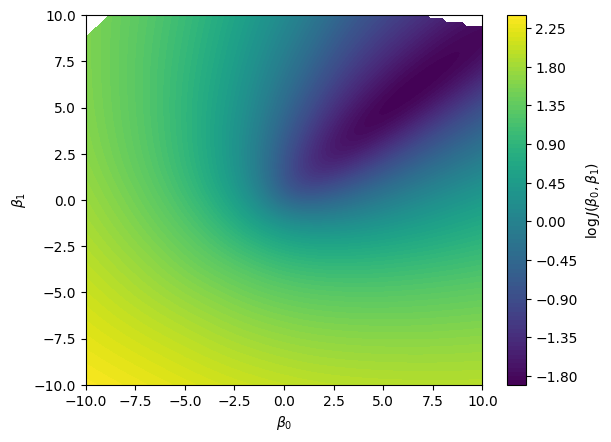

In [161]:
bb0, bb1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
bb = np.array([bb0.ravel(), bb1.ravel()]).T
ll = (X @ bb.T)
pp = 1 / (1 + np.exp(-ll))
jj = -np.log(pp) * y[:, None] - np.log(1. - pp) * (1. - y[:, None])
jj = jj.mean(axis=0).reshape(bb0.shape)

plt.contourf(bb0, bb1, np.log(jj), levels=100)
plt.xlabel(r"$\beta_0$")
plt.ylabel(r"$\beta_1$")
plt.colorbar().set_label(r"$\log{J(\beta_0, \beta_1)}$");

Katsayilarimiz icin bir baslangic noktasi secelim: $\beta = (-7.5, -7.5)$

Asagida bu baslangic noktasi icin hipotez fonksiyonumuzun ciktisini gormektesiniz:

Text(0, 0.5, '$x_2$')

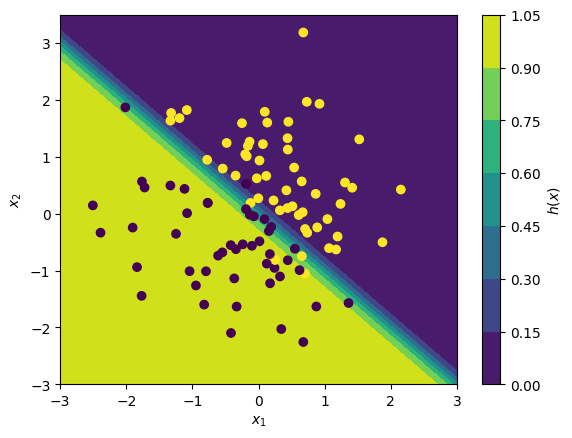

In [175]:
beta = np.array([-7.5, -7.5])
sabit = 0.0

olasi = 1 / (1 + np.exp(-np.array([xx.ravel(), yy.ravel()]).T @ beta + sabit))
olasi = olasi.reshape(xx.shape)

plt.contourf(xx, yy, olasi)
plt.colorbar().set_label("$h(x)$")
plt.scatter(*X.T, c=y);
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Guncelleme kuralimizin bir iterasyonunu yapalim:

Ilk maliyet:

In [176]:
z = X @ beta + sabit
yhat = 1 / (1 + np.exp(-z))

bce(y, yhat).sum()

805.6560939291887



$$ \frac{dJ}{d \beta} =X_i^T (\frac{1 - Y_i}{1 - \hat{Y}_i} - \frac{Y_i}{\hat{Y}_i}) (1 - \hat{Y_i}) \hat{Y_i}  $$


In [177]:
# lineer kisim Z'yi hesapla
z = X @ beta + sabit

# Hipotezin ciktisi
yhat = 1 / (1 + np.exp(-z))

dJdyhat = (1 - y)/(1 - yhat) - y/yhat
dyhatdz = yhat * (1 - yhat)
dzdbeta = X.T

dbeta = dzdbeta @ (dJdyhat * dyhatdz)
dsabit = (dJdyhat * dyhatdz).sum()

beta = beta - 1e-2 * dbeta
sabit = sabit - 1e-2 * dsabit

Guncellemeden sonra yeni maliyet:

In [178]:
z = X @ beta + sabit
yhat = 1 / (1 + np.exp(-z))

bce(y, yhat).sum()

746.7450872482625

Bu katsayi guncelleme islemini bir dongu ile optimal sonuca erisene kadar yapabiliriz.

### Regularizasyon ?

Mukemmel bir lineer ayrimin soz konusu olmasi durumunda, optimal maliyet ($0$), ancak parametreler sonsuza gittiginde elde edilebilir.

Ayrica, datasetimizde gereksiz degiskenlerin varligi ve *overfitting* durumlari da parametrelerin regularize edilmesine yol acacak ihtiyaclar arasinda sayilabilir.

Parametrelerin buyumesini engellemek icin, maliyet fonksiyonumuza parametrelerin mutlak buyuklukleri ile artacak bir terim ekleyebiliriz.

Bu durumda modelimiz, kullanilmasi gerekmeyen (kullanilmasi durumunda ayrima buyuk katki saglamayan) parametrelerin degerini $0$'a yaklastirabilir.

$$J(\hat{Y}, \beta) = (\sum_{i=0}^{m-1}{-Y_i \log{\hat{Y}_i} - (1 - Y_i) \log{(1 - \hat{Y}_i)}}) + \frac{1}{2}\lambda \sum_{j}{\beta_j^2}$$

Bu durumda katsayilarimiza gore turev ifadesine, onceki hesaplamamiza ek olarak $\lambda \beta$ eklememiz yeterli olacaktir.

$$ \frac{dJ}{d \beta} =X_i^T (\frac{1 - Y_i}{1 - \hat{Y}_i} - \frac{Y_i}{\hat{Y}_i}) (1 - \hat{Y_i}) \hat{Y_i} + \lambda \beta $$


Ornek olarak, asagidaki dataseti ele alalim:

$b=0$ icin, maliyeti minimum yapan $a$ katsayisi sizce kactir?

In [179]:
dummy_x = np.array([-3, -2, -1, 1, 2, 3])
dummy_y = np.array([0, 0, 0, 1, 1, 1])

@interact
def sigregviz(a=(-50,50,1), b=(-5, 5, 1)):
    plt.scatter(dummy_x, dummy_y, c=np.log(sigmoid(a*dummy_x + b)))
    plt.colorbar()
    t = np.linspace(-4, 4, 1000)
    plt.plot(t, sigmoid(a*t + b), label="sigmoid")
    plt.title(f"Kayip={bce(dummy_y, sigmoid(a*dummy_x + b)).sum()}")
    # plt.plot(dummy_x, a*dummy_x + b)
    # plt.show()


interactive(children=(IntSlider(value=0, description='a', max=50, min=-50), IntSlider(value=0, description='b'…

Asagidaki hucrede ise interaktif bir sekilde iterasyonlari arttirarak adim adim:
- hipotez fonksiyonumuzun ciktisinin degisimini,
- maliyetin degisimini,
- parametrelerimizin izledigi yolu

gorebilirsiniz.

In [168]:
bce(1, 0.9999999999)

1.000000082790371e-10

In [169]:
1 / (1 + np.exp(-99))

1.0

In [163]:
import warnings

In [181]:
@interact(iterasyon=(0,50,1), regularizasyon_etkisi=(0., 1., 0.1), ogrenme_orani=[0.5, 0.1, 0.01, 0.001])
def gradyanviz(iterasyon=0, regularizasyon_etkisi=0.0, ogrenme_orani=0.01):
    beta = np.array([-7.5, -7.5])
    sabit = 0.0
    maliyetler = []
    betayolu = [beta]
    LR = ogrenme_orani
    LAMDA = regularizasyon_etkisi

    for _ in range(iterasyon):
        z = X @ beta + sabit
        yhat = 1 / (1 + np.exp(-z))

        dbeta = X.T @ (  ((1 - y)/(1 - yhat) - y/yhat) * (1 - yhat) * yhat )
        dsabit = (  ((1 - y)/(1 - yhat) - y/yhat) * (1 - yhat) * yhat ).sum()

        # REGULARIZASYON KISMI: LAMBDA * beta
        beta = beta - LR * dbeta - LR * LAMDA * beta 
        
        betayolu.append(beta)
        # sabit = sabit - LR * dsabit
        maliyet = -np.sum(y * np.log(yhat) + (1 - y) * np.log(1 - yhat)) + LAMDA * (beta**2).sum()
        maliyetler.append(maliyet)
    
    olasi = 1 / (1 + np.exp(-np.array([xx.ravel(), yy.ravel()]).T @ beta + sabit))
    olasi = olasi.reshape(xx.shape)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.contourf(xx, yy, olasi, levels=3)
    plt.scatter(*X.T, c=y, edgecolors='k')
    plt.title(f"beta={beta}, intersept={sabit}");
    plt.subplot(1, 4, 2)
    plt.plot(maliyetler[-10:], marker='o')
    # plt.ylim(-3, 120)
    plt.grid()
    plt.xlabel("Iterasyon")
    plt.ylabel("Maliyet")
    plt.title("Maliyet (Son 10)")

    plt.subplot(1, 4, 3)
    bb0, bb1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    bb = np.array([bb0.ravel(), bb1.ravel()]).T
    ll = (X @ bb.T)
    pp = 1 / (1 + np.exp(-ll))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        jj = -np.log(pp) * y[:, None] - np.log(1 - pp) * (1 - y[:, None])
    jj = jj.sum(axis=0).reshape(bb0.shape) + LAMDA * (bb0**2 + bb1**2)
    # print(jj.min(), jj.max())

    plt.contourf(bb0, bb1, np.log(jj))
    plt.xlabel("beta0")
    plt.ylabel("beta1")
    plt.title("Katsayilarin izledigi yol")
    aze = plt.plot(*np.array(betayolu).T, c='r', marker='o')

    plt.subplot(1, 4, 4)
    betayolu = np.array(betayolu)
    aze = plt.plot(*np.array(betayolu)[-15:].T, c='r', marker='o')[0]
    # print(aze)
    xlim = aze.axes.get_xlim()
    ylim = aze.axes.get_ylim()
    

    bb0, bb1 = np.meshgrid(np.linspace(*xlim, 100), np.linspace(*ylim, 100))
    bb = np.array([bb0.ravel(), bb1.ravel()]).T
    ll = (X @ bb.T)
    pp = 1 / (1 + np.exp(-ll))
    jj = -np.log(pp) * y[:, None] - np.log(1 - pp) * (1 - y[:, None])
    jj = jj.sum(axis=0).reshape(bb0.shape) + LAMDA * (bb0**2 + bb1**2)
    # print(jj.min(), jj.max())

    plt.contourf(bb0, bb1, np.log(jj))
    plt.xlabel("beta0")
    plt.ylabel("beta1")
    plt.title("Katsayilarin izledigi yol (Son 10)")
    aze = plt.plot(*np.array(betayolu)[-10:].T, c='r', marker='o')


interactive(children=(IntSlider(value=0, description='iterasyon', max=50), FloatSlider(value=0.0, description=…

### Hipotezimizin logit kismi: g(x)

Hipotez fonksiyonumuzun

$$h(x) = \frac{1}{1 + e^{-g(x)}}$$

seklinde ifade edilebileceginden bahsedip, logit kismi $g(x)$ icin lineer bir fonksiyon ($g(x) = {X\beta}$) kullanarak bir tasniflendirme denemesi yaptik.

Eger zincir kuralini kullanacaksak, $g(x)$'i daha kompleks (ve daha guclu) bir hale getiremez miyiz?



Ornegin, asagidaki gibi cok katmanli bir sistem, benzer adimlar izleyerek optimize edilebilir mi?

![](graph.png)

## Cok katmanli perceptron (MLP - multilayer perceptron)

Cok katmanli perceptron icin, yukaridaki semayi baz alarak bir sistem kurabiliriz.

Ihtiyacimiz olanlar:
- $\beta_1$
- $sabit_1$
- $\beta_2$
- $sabit_2$

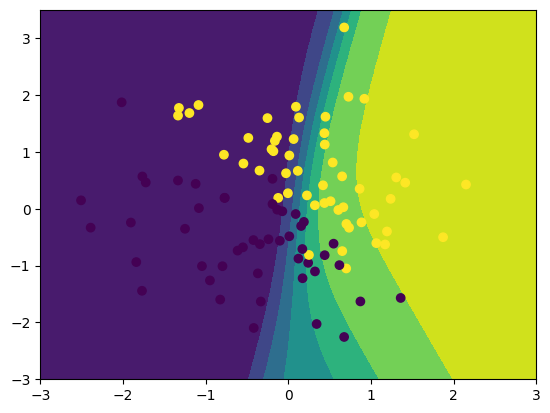

In [180]:
beta1 = np.array([[-5.0, 2.5], [1.0, 1.0]])
sabit1 = np.array([0.0, 0.0])
beta2 = np.array([-5.0, 2.5])
sabit2 = 0.0

def forward(X, beta1, sabit1, beta2, sabit2):
    z1 = X @ beta1 + sabit1
    a1 = 1 / (1 + np.exp(-z1))
    z2 = a1 @ beta2 + sabit2
    return z2



z = forward(np.array([xx.ravel(), yy.ravel()]).T, beta1, sabit1, beta2, sabit2)
olasi = 1 / (1 + np.exp(- z))
olasi = olasi.reshape(xx.shape)

plt.contourf(xx, yy, olasi)
plt.scatter(*X.T, c=y)

Cok katmanli perceptron ile ilgili hipotez fonksiyonunda gozumuze ilk carpan detay nedir?

Cok katmanli perceptron'umuzun ciktisini hesaplamak icin kullandigimiz adimlari yazarsak:

(sigmoid fonksiyonunu $\sigma(x)$ olarak gostererek)

$$Z_1 = X \beta_1 + sabit_1$$
$$A_1 = \sigma(Z_1) $$
$$Z_2 = A_1 \beta_2 + sabit_2$$
$$A_2 = \sigma(Z_2)$$
$$\hat{Y} = A_2$$
$$ J(\hat{Y}) = \sum_{i=0}^{m-1}{-Y_i \log{\hat{Y}_i} - (1 - Y_i) \log{(1 - \hat{Y}_i)}} $$

Yukaridaki gorece basit sistemde kullandigimiz zincir kurali ile bu sistemi de optimize edebilir miyiz?

$$ \frac{dJ}{d\beta_2} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2} \frac{d Z_2}{d \beta_2}$$
$$ \frac{dJ}{dsabit_2} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2}$$
$$ \frac{dJ}{d\beta_1} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2} \frac{d Z_2}{d A_1} \frac{d A_1}{d Z_1} \frac{dZ_1}{d\beta_1}$$
$$ \frac{dJ}{dsabit_1} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2} \frac{d Z_2}{d A_1} \frac{d A_1}{d Z_1}$$

Bazi parametrelerin turevlerinin ilk sistemimizden hicbir farki olmadigini gorurken, sistemde geriye (semada sol tarafa) gittikce yalnizca ek carpanlar eklendigini goruyoruz.

Bir iterasyon icin guncelleme kuralimizi yazalim:

##### Baslatma

Parametrelerimiz icin baslangic degerleri secelim (rastgele degerler sectik):

In [183]:
beta1 = np.array([[-5.0, 2.5], [1.0, 1.0]])
sabit1 = np.array([0.0, 0.0])
beta2 = np.array([[-5.0], [2.5]])
sabit2 = 0.0
alpha = 1e-1 # Ogrenme orani

##### Ileri besleme

Bu kisimda orneklerimizi, sistemimizde ilerleterek tahminimizi yapacagiz

In [184]:
z1 = X @ beta1 + sabit1
a1 = sigmoid(z1)
z2 = a1 @ beta2 + sabit2
yhat = sigmoid(z2)

Baslangic maliyetimiz:

In [185]:
y1 = y[:, None]

In [186]:
bce(y1, yhat).sum()

87.07174755348314

##### Geri yayilim (Backpropagation)

Bu kisimda ise, ortaya cikan hatanin turevini geri dogru zincirleme bir sekilde alacagiz

In [187]:
dyhat = (1 - y1) / (1 - yhat) - (y1 / yhat)
dz2 = yhat * (1 - yhat) * dyhat

dbeta2 = a1.T @ (dz2)
dsabit2 = (dz2).sum()

da1 = dz2 @ beta2.T
dz1 = a1 * (1 - a1) * da1

dbeta1 = X.T @ dz1
dsabit1 = dz1.sum(axis=0)

Guncellemelerimizi yapalim:

In [188]:
beta1 = beta1 - alpha * dbeta1
sabit1 = sabit1 - alpha * dsabit1

beta2 = beta2 - alpha * dbeta2
sabit2 = sabit2 - alpha * dsabit2

Yeni maliyetimizi kontrol edelim:

In [189]:
# ileri besleme
z1 = X @ beta1 + sabit1
a1 = sigmoid(z1)
z2 = a1 @ beta2 + sabit2
yhat = sigmoid(z2)

# hata hesaplama
bce(y1, yhat).sum()

50.25753798357398

Parcalari birlestirip, guncellememizi verilen bir iterasyon sayisi kadar tekrar edelim:

In [201]:
np.random.seed(42)
beta1 = np.array([[-5.0, 2.5], [1.0, 1.0]])
sabit1 = np.array([0.0, 0.0])
beta2 = np.array([[-5.0], [2.5]])
sabit2 = 0.0
maliyetler = []
alpha = 1e-1
# betayolu = [beta]
iterasyon = 20

for _ in range(iterasyon):
    z1 = X @ beta1 + sabit1
    a1 = sigmoid(z1)
    z2 = a1 @ beta2 + sabit2
    yhat = sigmoid(z2)

    dyhat = (1 - y1) / (1 - yhat) - (y1 / yhat)
    dz2 = yhat * (1 - yhat) * dyhat

    dbeta2 = a1.T @ (dz2)
    dsabit2 = (dz2).sum()

    da1 = dz2 @ beta2.T
    dz1 = a1 * (1 - a1) * da1

    dbeta1 = X.T @ dz1
    dsabit1 = dz1.sum(axis=0)

    beta1 = beta1 - alpha * dbeta1
    sabit1 = sabit1 - alpha * dsabit1

    beta2 = beta2 - alpha * dbeta2
    sabit2 = sabit2 - alpha * dsabit2

    # dbeta = X.T @ (  ((1 - y)/(1 - yhat) - y/yhat) * (1 - yhat) * yhat )
    # dsabit = (  ((1 - y)/(1 - yhat) - y/yhat) * (1 - yhat) * yhat ).sum()

    # beta = beta - alpha * dbeta
    # betayolu.append(beta)
    # sabit = sabit - alpha * dsabit
    maliyet = bce(y1, yhat).sum()
    maliyetler.append(maliyet)

Text(0, 0.5, 'Maliyet')

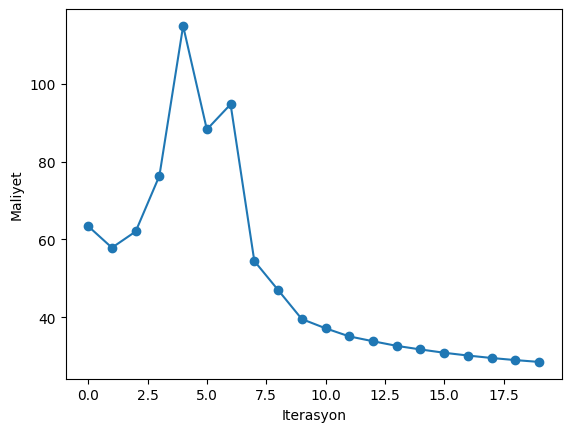

In [202]:
plt.plot(maliyetler, marker='o')
plt.xlabel("Iterasyon")
plt.ylabel("Maliyet")

Hipotez fonksiyonumuzun ciktisi:

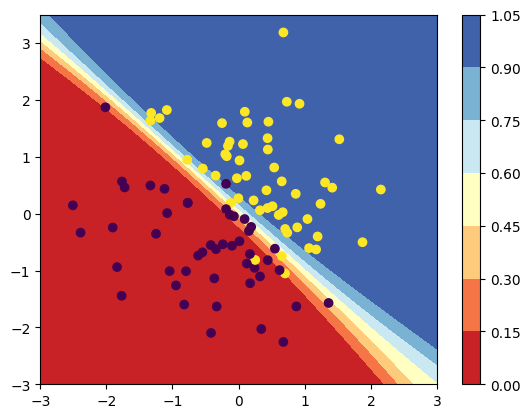

In [192]:
XXravel = np.array([xx.ravel(), yy.ravel()]).T
ZZ1 = XXravel @ beta1 + sabit1
AA1 = sigmoid(ZZ1)
ZZ2 = AA1 @ beta2 + sabit2
AA2 = sigmoid(ZZ2)

AA2 = AA2.reshape(xx.shape)

plt.contourf(xx, yy, AA2, cmap='RdYlBu')
plt.colorbar()
plt.scatter(*X.T, c=y)

Kodumuzu daha moduler bir hale getirmek icin, parcalari tekrar tekrar kullanilabilir fonksiyonlara cevirelim:

In [193]:
def feedForward(X, beta1, sabit1, beta2, sabit2):
    """Ileri beslemeyi tatbik et.
    
    Ileri besleme, verilen datanin katsayilarla carpilip sabitlerle toplanmasi
    ve belirlenen donusumlerin yapilmasindan sonra hipotez fonksiyonunun
    ciktisinin alinmasi islemi olacaktir.
    """
    z1 = X @ beta1 + sabit1
    a1 = sigmoid(z1)
    z2 = a1 @ beta2 + sabit2
    yhat = sigmoid(z2)
    return yhat, a1

def backPropagate(X, y, beta1, sabit1, beta2, sabit2, a1, yhat, alpha):
    """Geri yayilimi tatbik et.
    
    Ileri beslemede elde edilen hatanin, sistem boyunca geri dogru yayilarak
    katsayi ve sabitlerin guncellenmesini saglayan fonksiyon.
    """
    dyhat = (1 - y) / (1 - yhat) - (y / yhat)
    dz2 = yhat * (1 - yhat) * dyhat
    dbeta2 = a1.T @ (dz2)
    dsabit2 = (dz2).sum()

    da1 = dz2 @ beta2.T
    dz1 = a1 * (1 - a1) * da1
    dbeta1 = X.T @ dz1
    dsabit1 = dz1.sum(axis=0)

    beta1 = beta1 - alpha * dbeta1
    sabit1 = sabit1 - alpha * dsabit1

    beta2 = beta2 - alpha * dbeta2
    sabit2 = sabit2 - alpha * dsabit2
    return beta1, sabit1, beta2, sabit2

#### Daha kompleks karar sinirlari

Elimizdeki sistemi kullanarak, daha zor (lineer olarak ayrilmayan) bir verisetini tasniflendirmeyi deneyebiliriz.

In [204]:
X, y = datasets.make_circles()
y1 = y[:, None]

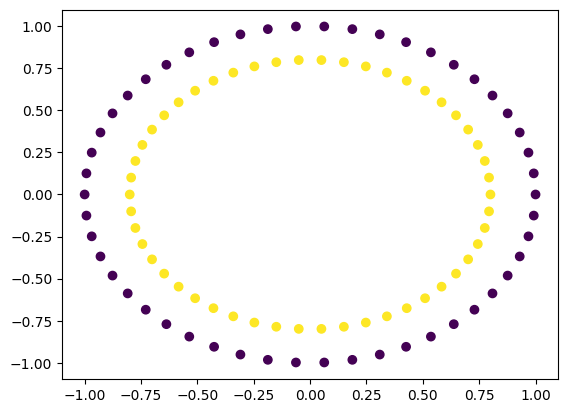

In [205]:
plt.scatter(*X.T, c=y);

Asagidaki interaktif hucrede iterasyonlara sari olarak hipotez fonksiyonunun ciktisinin degisimini gozlemleyebilirsiniz.

> Ek olarak, sagdaki sekilde gizli katmanin ciktisini (3 boyutlu) gormektesiniz.

(Bu kez daha sabirli olmamiz gerekecek.)

In [196]:
def graphviz(iterasyon=0):

    # Baslangic degerleri
    np.random.seed(42)
    GIZLI_KATMAN_BOYUTU = 3
    beta1 = np.random.randn(2, GIZLI_KATMAN_BOYUTU)
    sabit1 = np.zeros(GIZLI_KATMAN_BOYUTU)
    beta2 = np.random.randn(GIZLI_KATMAN_BOYUTU, 1)
    sabit2 = 0.0
    alpha = 1e-2

    # Diyagnostik icin
    maliyetler = []

    # Optimizasyon
    for _ in range(iterasyon):
        yhat, a1 = feedForward(X, beta1, sabit1, beta2, sabit2)
        beta1, sabit1, beta2, sabit2 = backPropagate(X, y1, beta1, sabit1, beta2, sabit2, a1, yhat, alpha)

        maliyet = bce(y1, yhat)
        maliyet = np.sum(maliyet)
        maliyetler.append(maliyet)

    # Gorseller
    olasi = feedForward(np.array([xx.ravel(), yy.ravel()]).T, beta1, sabit1, beta2, sabit2)[0]    
    olasi = olasi.reshape(xx.shape)

    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, olasi, vmin=0, vmax=1, cmap=plt.cm.bone_r, levels=40)
    plt.colorbar().set_label('$\hat{y}$')
    plt.scatter(*X.T, c=y, edgecolors='k')
    plt.title("Hipotez fonksiyonu ciktisi (dataset uzayi)")

    if iterasyon > 0:
        # fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1,2, 2,projection='3d', elev=45, azim=45)
        ax.scatter(a1[:, 0], a1[:, 1], a1[:, 2], c=y)
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")
    else:
        ax = fig.add_subplot(1,2, 2,projection='3d', elev=45, azim=45)
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")

interact(iterasyon=(0,5000,100))(graphviz);

interactive(children=(IntSlider(value=0, description='iterasyon', max=5000, step=100), Output()), _dom_classes…

MLP, orjinal dataset uzayini 3 boyutlu (ya da konfigurasyona gore daha da yuksek boyutlu) bir uzaya haritaliyor.

> Bu haritalamada dikkatinizi ceken bir durum var mi? 
>- 5000. iterasyonda, gizli katman uzayinda, siyah ve sari noktalari tam olarak ayirabilecek bir duzlem kullanilabilir mi?
>- Gizli katman uzayinda noktalar, aralarina bir duzlem girebilecek duruma geldiginde soldaki sekilde ne goruyorsunuz?
>- Hipotez fonksiyonu ile siniflar uyumsuzken, gizli katman uzayinda noktalarin durumu nedir?

Benzer bir haritalamayi `moons` datasetinde de inceleyebiliriz:

In [197]:
X, y = datasets.make_moons()
y1 = y[:, None]

In [198]:
# @lru_cache(maxsize=50000)
def graphviz(iterasyon=0):

    # Baslangic degerleri
    np.random.seed(42)
    GIZLI_KATMAN_BOYUTU = 3
    beta1 = np.random.randn(2, GIZLI_KATMAN_BOYUTU)
    sabit1 = np.zeros(GIZLI_KATMAN_BOYUTU)
    beta2 = np.random.randn(GIZLI_KATMAN_BOYUTU, 1)
    sabit2 = 0.0
    alpha = 1e-2

    # Diyagnostik icin
    maliyetler = []

    # Optimizasyon
    for _ in range(iterasyon):
        yhat, a1 = feedForward(X, beta1, sabit1, beta2, sabit2)
        beta1, sabit1, beta2, sabit2 = backPropagate(X, y1, beta1, sabit1, beta2, sabit2, a1, yhat, alpha)

        maliyet = bce(y1, yhat)
        maliyet = np.sum(maliyet)
        maliyetler.append(maliyet)

    # Gorseller
    olasi = feedForward(np.array([xx.ravel(), yy.ravel()]).T, beta1, sabit1, beta2, sabit2)[0]    
    olasi = olasi.reshape(xx.shape)

    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, olasi, vmin=0, vmax=1, cmap=plt.cm.bone_r, levels=40)
    plt.colorbar().set_label('$\hat{y}$')
    plt.scatter(*X.T, c=y, edgecolors='k')
    plt.title("Hipotez fonksiyonu ciktisi (dataset uzayi)")

    if iterasyon > 0:
        # fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1,2, 2,
        projection='3d', elev=45, azim=45
        )
        ax.scatter(
            a1[:, 0], 
            a1[:, 1], 
            a1[:, 2], 
            c=y)
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")
    else:
        ax = fig.add_subplot(1,2, 2,
        projection='3d', elev=45, azim=45
        )
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")

interact(iterasyon=(0,5000,100))(graphviz);

interactive(children=(IntSlider(value=0, description='iterasyon', max=5000, step=100), Output()), _dom_classes…